In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [14]:
import torch
import numpy as np 
import os

from typing import List, Tuple

from torch.utils.data import Dataset

from PIL import Image

class COCOInstanceDataset(Dataset):
    def __init__(self, dataset_dir: str = "dataset/train/"):
        self.dataset_dir = dataset_dir
        self.data = __class__.get_mask_image_pairs(dataset_dir)

    @staticmethod
    def get_mask_image_pairs(directory: str) -> List[Tuple[str, str]]:
        mask_image_pairs = [
            (
                os.path.join(directory, filename),
                os.path.join(directory, f"{os.path.splitext(filename)[0]}_mask.png")
            )
            for filename in os.listdir(directory)
            if filename.endswith(".jpg") and os.path.isfile(os.path.join(directory, f"{os.path.splitext(filename)[0]}_mask.png"))
        ]
        return mask_image_pairs
        
    def __getitem__(self, idx: int):
        img_file, mask_file = self.data[idx]
        img = Image.open(img_file).convert("RGB")
        mask = Image.open(mask_file) 

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        num_objs = len(obj_ids)

        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True

        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])

        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return T.ToTensor()(img), target, img, mask
    
    def __len__(self):
        return len(self.data)

In [29]:
dataset = COCOInstanceDataset(dataset_dir="dataset/train/")
img_t, target, img, mask = dataset[14]

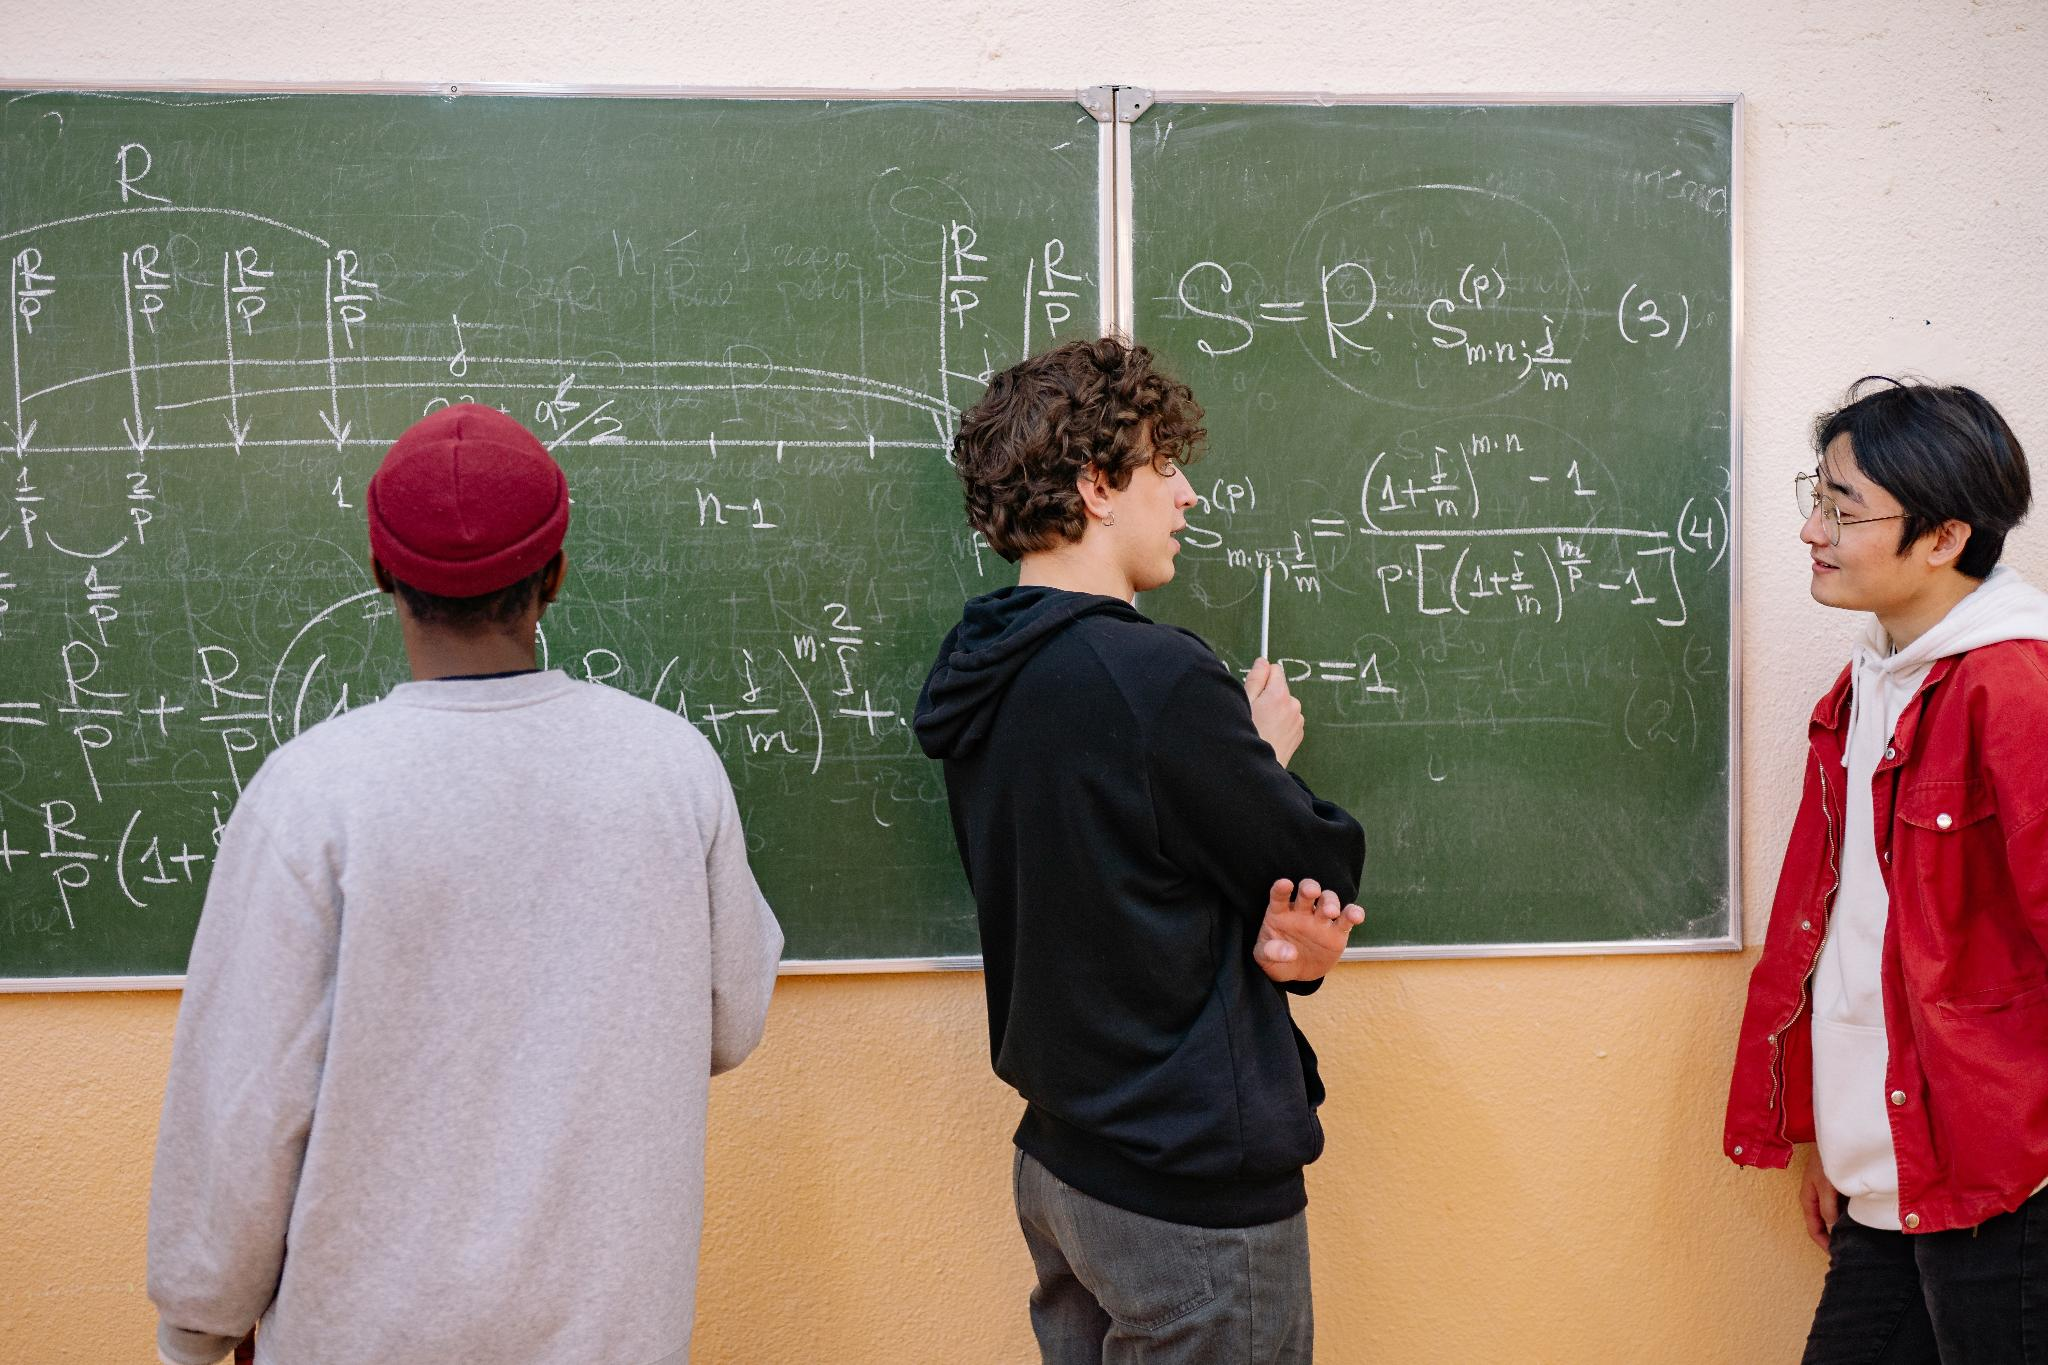

In [30]:
img

In [31]:
np.unique(mask)

array([0, 1], dtype=uint8)

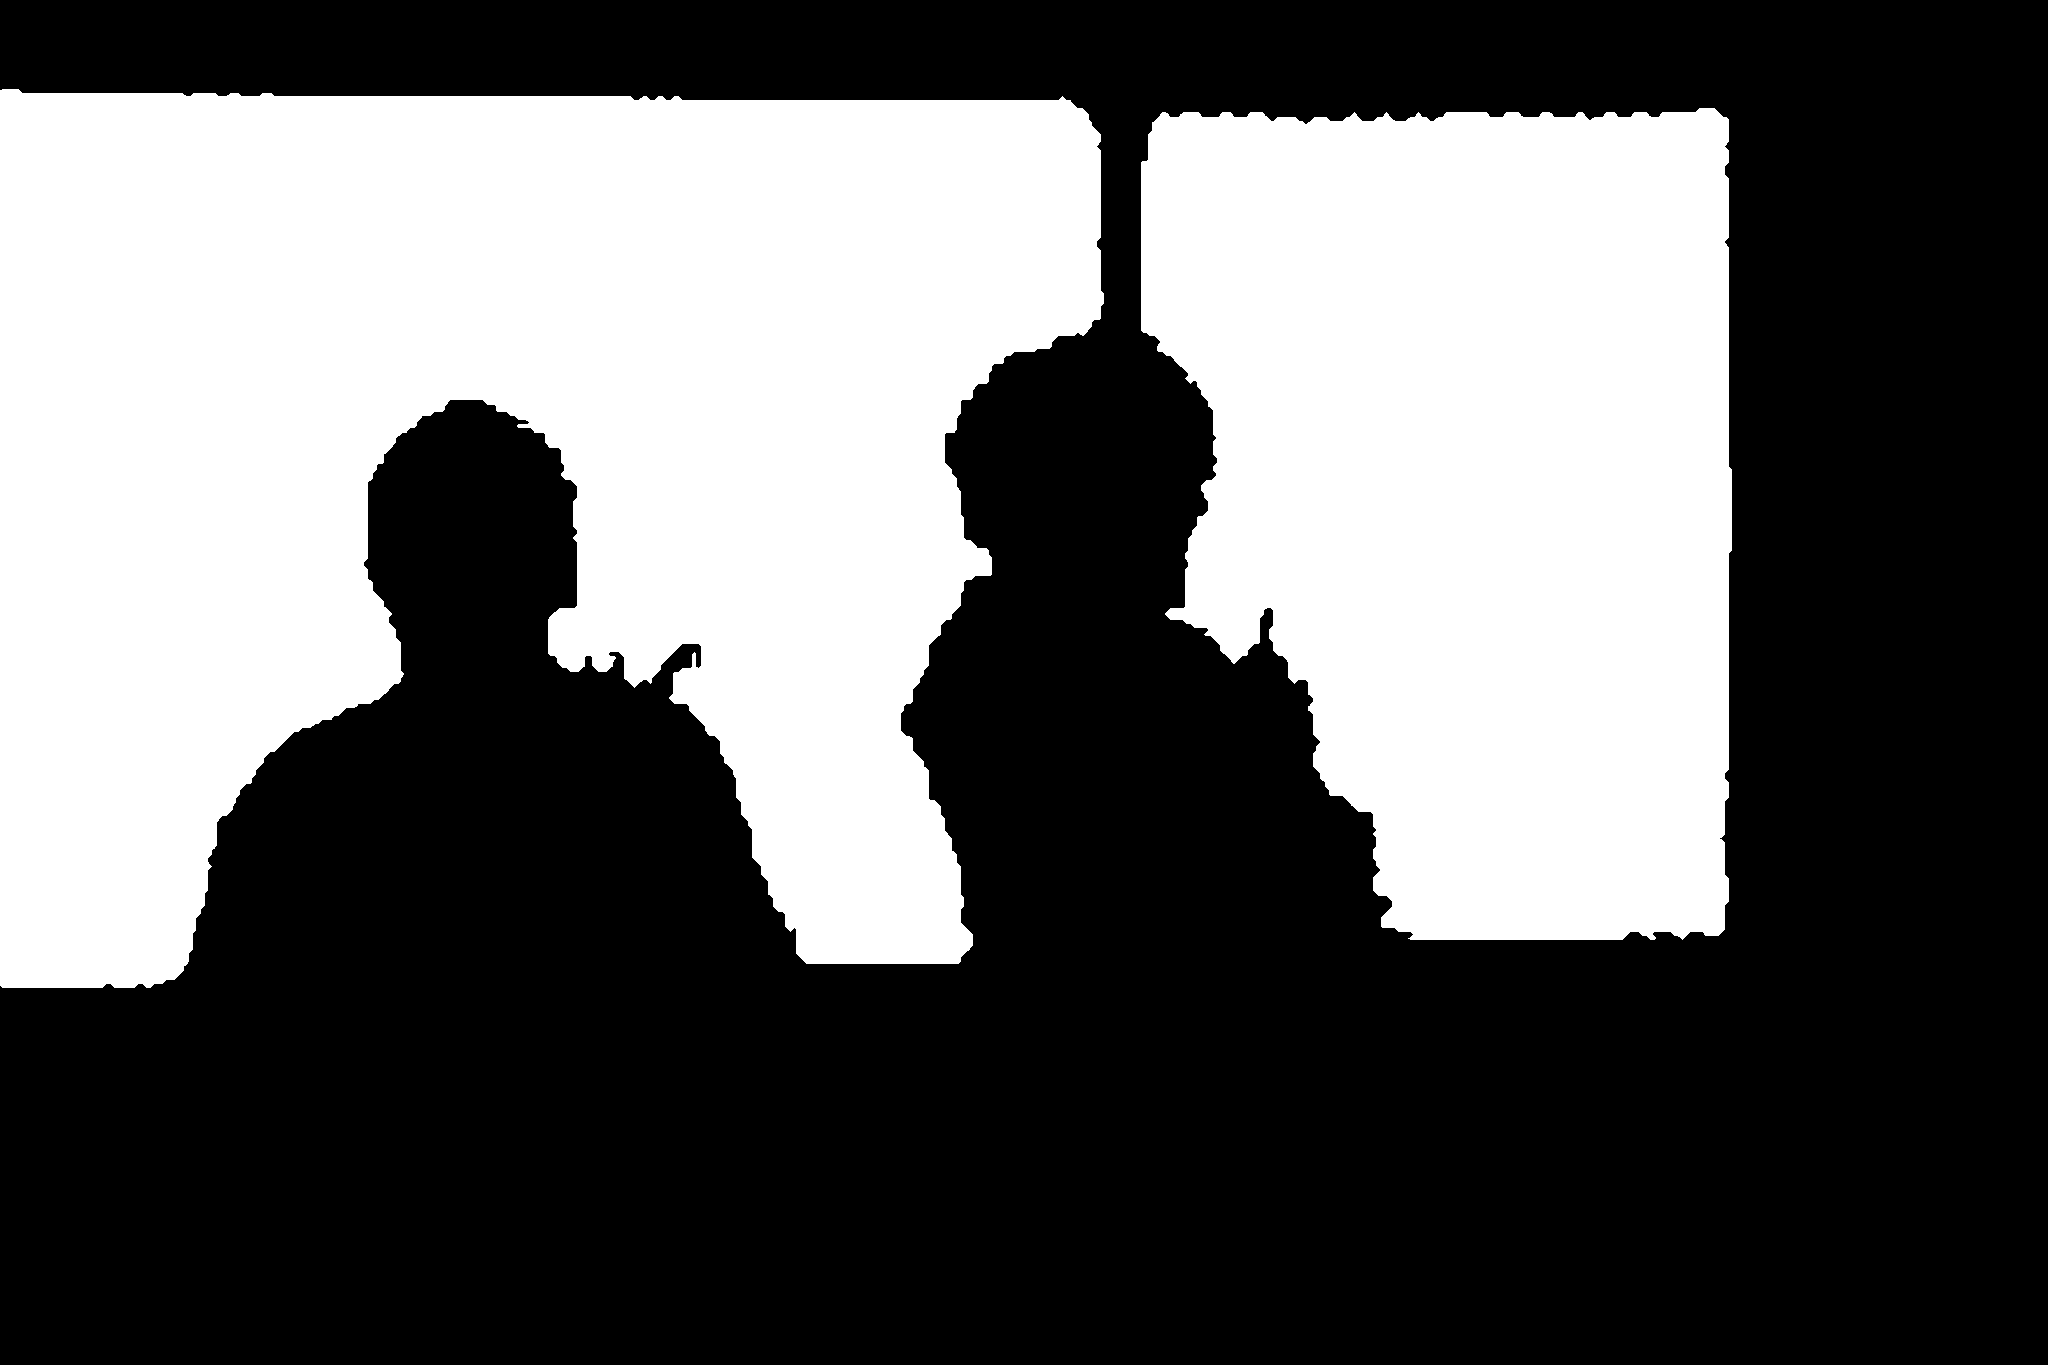

In [32]:
Image.fromarray(np.array(mask) == 1)

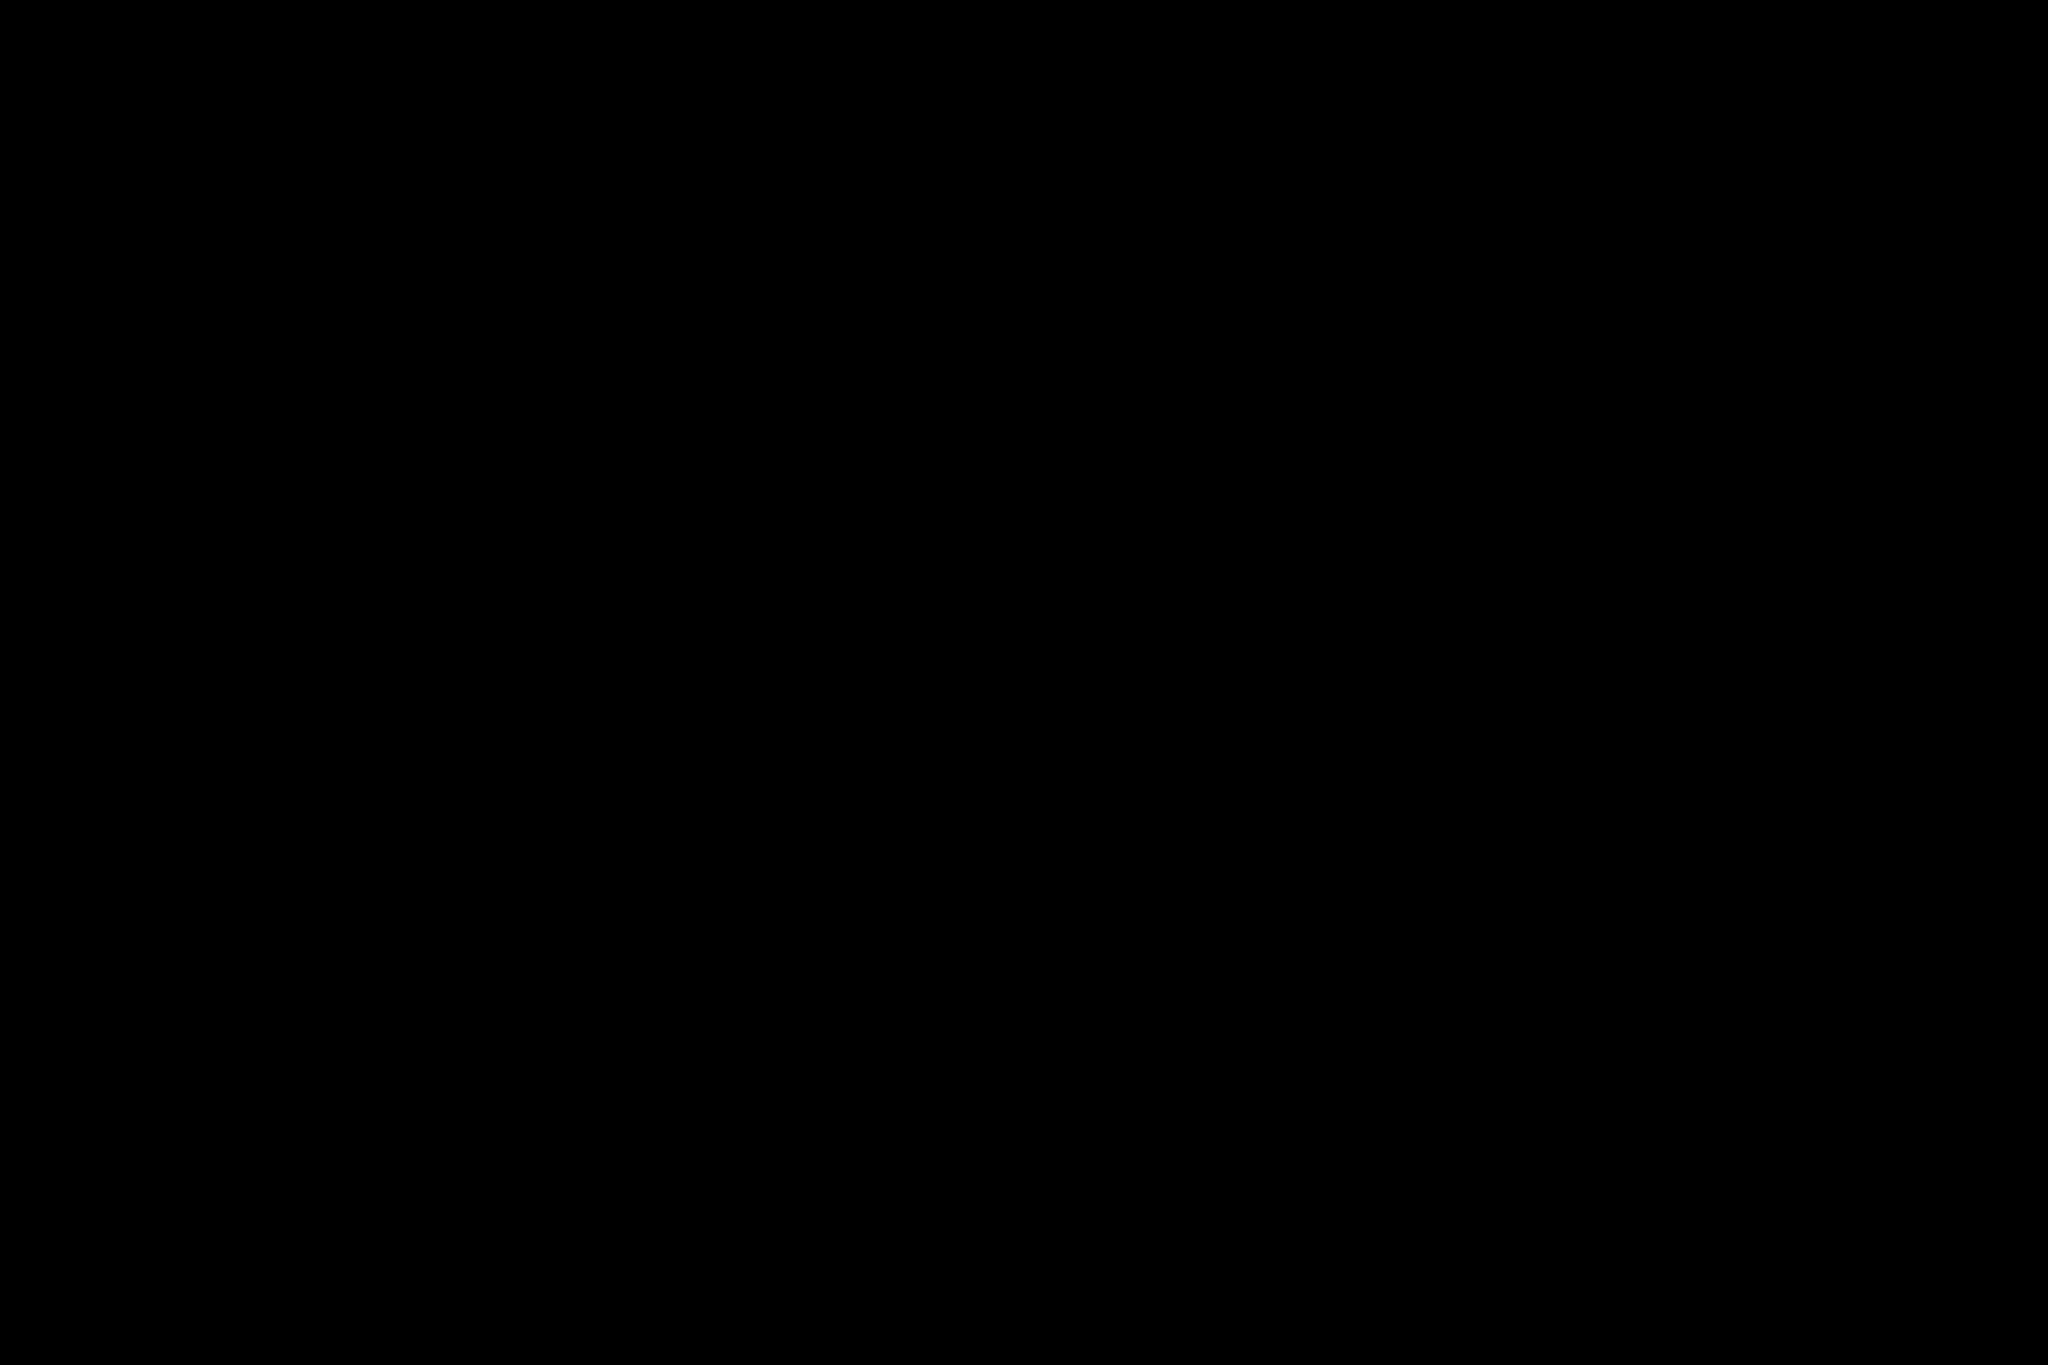

In [33]:
Image.fromarray(np.array(mask) == 2)

In [34]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [35]:
transform = T.ToTensor()

In [36]:
def custom_collate(data):
  return data

In [37]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate, num_workers=1, pin_memory=torch.cuda.is_available())

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [40]:
params = [p for p in model.parameters() if p.requires_grad]

In [41]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [42]:
def train_model(model, dataloader: DataLoader, epochs: int = 10):
	all_train_losses = []

	for epoch in range(epochs):
		train_epoch_loss = 0
		model.train()

		for i , dt in enumerate(dataloader):
			imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
			targ = [dt[0][1] , dt[1][1]]
			targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
			loss = model(imgs , targets)
			losses = sum([l for l in loss.values()])
			train_epoch_loss += losses.cpu().detach().numpy()
			optimizer.zero_grad()
			losses.backward()
			optimizer.step()

			print(f"{i=} : {losses=}")

		all_train_losses.append(train_epoch_loss)
		print(epoch , "  " , train_epoch_loss)

	return all_train_losses

In [43]:
all_train_losses = train_model(model, dataloader=dataloader, epochs=30)

plt.plot(all_train_losses)

i=0 : losses=tensor(2.5950, device='cuda:0', grad_fn=<AddBackward0>)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_1962664/995076957.py", line 47, in __getitem__
    xmin = np.min(pos[1])
           ^^^^^^^^^^^^^^
  File "/home/elal/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 2953, in min
    return _wrapreduction(a, np.minimum, 'min', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/elal/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 88, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: zero-size array to reduction operation minimum which has no identity


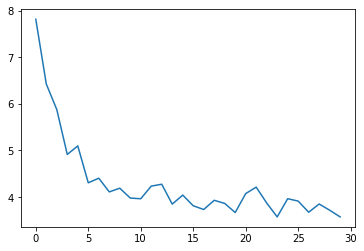

In [21]:
plt.plot(all_val_losses)

In [22]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

--2023-03-26 05:32:14--  https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.15.16, 104.18.14.16, 2606:4700::6812:e10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.15.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206784 (202K) [binary/octet-stream]
Saving to: ‘couple-3687274_960_720.jpg’

couple-3687274_960_ 100%[===================>] 201.94K  --.-KB/s    in 0.03s   

2023-03-26 05:32:16 (6.80 MB/s) - ‘couple-3687274_960_720.jpg’ saved [206784/206784]



In [24]:
model.eval()
img = Image.open("/kaggle/working/couple-3687274_960_720.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [ ]:
img

In [ ]:
pred

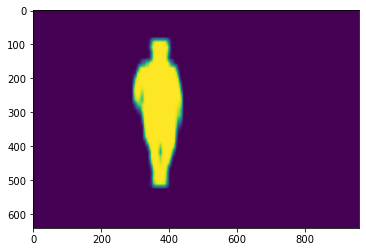

In [29]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [28]:
img.size

(960, 641)